# Instructions

The goals of this practical session:
  1. (warm-up) evaluate empirically 2 given bandit algorithms
  1. (core) implement one of the course algorithms: either UCB or Thompson Sampling (optionally EXP3)
  1. (core) test it on a practical use case (path selection for network routing)
  1. (optional) experiment with the adversarial case

## Dataset

We will use an open dataset to simulate a network routing problem: 
- at each round the bandit has the choice between K routes to send his packet
- the chosen route reveals its latency when it is used
The goal is to minimize the overall latency.

To make it easier we will discretize the latency to work on a binary problem.

In [1]:
%pylab inline
import pandas as pd
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [2]:
%cat data/univ-latencies/license.txt

UsageError: Line magic function `%cat` not found.


In [3]:
df = pd.read_csv('data/univ-latencies/univ-latencies.txt')

In [4]:
print("Latency of some homepages in the first timesteps")
df.iloc[:10,:5]

Latency of some homepages in the first timesteps


,acu-edu,acadiau-ca,adrian-edu,agnesscott-edu,aims-edu
0,396,381,488,506,333
1,271,261,488,504,276
2,271,141,325,545,266
3,268,136,324,1946,331
4,273,136,321,549,290
5,268,144,543,545,284
6,271,142,290,472,275
7,316,136,339,2162,372
8,268,136,286,464,263
9,531,409,320,470,315


<AxesSubplot:title={'center':'Latency over time for a few universities'}>

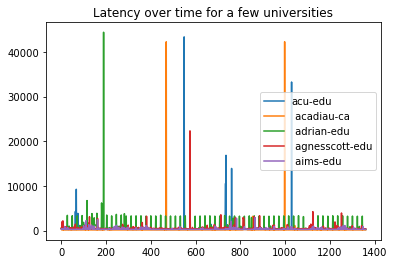

In [5]:
df.iloc[:,:5].plot(title='Latency over time for a few universities')

The dataset is transformed so as to come back to a Bernoulli problem. The reward is:
- 1 if latency is < threshold
- 0 if latency is > threshold

for an arbitrary latency threshold.

The task boils down to exploring which universities have the lowest latency and exploiting this knowledge to minimize the sum of latencies until the end of the experiment.

In [6]:
print("Mean reward for a few arms")
(df.iloc[:,:5] > 500).astype(int).mean()

Mean reward for a few arms


acu-edu            0.021308
 acadiau-ca        0.016899
 adrian-edu        0.131521
 agnesscott-edu    0.146216
 aims-edu          0.069067
dtype: float64

In [7]:
def get_dataset(n_arms, n_steps=None, max_latency=None, quantile=.5, shuffle=True):
    """
    return a binary dataset.
    
    n_arms: nb of pullable arms
    max_latency: criteria to decide if latency is good/bad (default: inferred from quantile)
    quantile: proportion of "1" labels
    """
    df = pd.read_csv('data/univ-latencies/univ-latencies.txt')
    if n_arms > df.shape[1]:
        raise Exception("Please specify max %d arms" % df.shape[1])
    if max_latency is None:
        max_latency = df.iloc[:,:n_arms].mean().quantile(quantile)
    raw_vector = (df.iloc[:,:n_arms] < max_latency).astype(int)
    if shuffle:
        raw_vector = raw_vector.sample(frac=1)
    if n_steps is None:
        return raw_vector
    if raw_vector.shape[0] > n_steps:
        return raw_vector.iloc[:n_steps-1,:]
    v = raw_vector.sample(n=n_steps, replace=True, random_state=42)
    v.index = np.arange(v.shape[0])
    return v

In [8]:
def adversarialize(ddf, nb_episods=2):
    ddf = ddf.copy()
    episod_len = int(ddf.shape[0]/nb_episods)
    #print("len", ddf.shape[0], "epilen", episod_len)
    for _ in range(nb_episods):
        start = _*episod_len
        end = min((_+1)*episod_len, ddf.shape[0])
        #print("epi", _, start, end)
        for col in range(ddf.shape[1]):
            ddf.iloc[start:end,col] = np.sort(ddf.iloc[start:end,col])
            if np.random.randint(0,2) > 0:
                ddf.iloc[start:end,col] = np.flip(ddf.iloc[start:end,col])
    ddf.index = np.arange(ddf.shape[0])
    return ddf

In [9]:
get_dataset(5, quantile=.5).mean()

acu-edu            0.964732
 acadiau-ca        0.980162
 adrian-edu        0.788391
 agnesscott-edu    0.467303
 aims-edu          0.907421
dtype: float64

# Provided Code

## Bandit API

In [10]:
class Bandit():
    def __init__(self, n_arms):
        self.n_arms = n_arms
    def pull(self) -> int:
        """Choose an arm."""
        raise NotImplemented()
    def feedback(self, arm: int, reward):
        """Process feedback"""
        raise NotImplemented()

In [11]:
def test_API(bandit_class):
    bandit = bandit_class(2)
    arm = bandit.pull()
    assert type(arm) in (int, np.int, np.int16, np.int32, np.int64), type(arm)
    bandit.feedback(0, 0)
    bandit.feedback(0, 1)
    bandit.feedback(1, 0)
    bandit.feedback(1, 1)
    print(bandit_class.__name__ + " sounds correct.")

## Given Bandit Implems

In [12]:
class EpsilonGreedy(Bandit):
    def __init__(self, n_arms, epsilon=.1):
        Bandit.__init__(self, n_arms)
        self.epsilon = epsilon
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        if np.random.random() < self.epsilon:
            arm = np.random.choice(np.arange(self.n_arms))
            return arm
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        return np.argmax(arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] += 1
        self.reward_sum_per_arm[arm] += reward

In [13]:
class WeightedRandomBandit(Bandit):
    """Play a random action according to $\hat{X_{i,t}}$."""
    def __init__(self, n_arms):
        Bandit.__init__(self, n_arms)
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)        
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 10]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        arms_weights = arms_weights / np.sum(arms_weights)
        return np.random.choice(self.n_arms, p=arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] = self.actions_per_arm[arm] + 1
        self.reward_sum_per_arm[arm] = self.reward_sum_per_arm[arm] + reward

## Evaluation

This class is mainly a helper to analyze the behavior of different bandit algorithms.

You may extend it if you want additional insight into an algorithm behavior.

In [14]:
class Experiment():
    """Given a Bandit, run an experiment and compute regret."""
    
    def __init__(self, n_arms:int, n_steps:int, adversarial:int=0):
        # data
        self.n_arms = n_arms
        self.data = get_dataset(n_arms, n_steps=n_steps)
        if adversarial > 0:
            self.data = adversarialize(self.data, nb_episods=adversarial)
        self.n_turns = self.data.shape[0]
        # regret analysis variables
        self.actions = []
        self.rewards = []
        self.stochastic_regrets = []
        # algo analysis variables
        self.actions_per_arm = np.zeros(self.n_arms)
        self.reward_sum_per_arm = np.zeros(self.n_arms)
        self.exploration = []
        
    def run(self, b: Bandit):
        for t in range(self.data.shape[0]):
            # bandit action
            chosen_arm = b.pull()
            reward = self.data.iloc[t, chosen_arm]
            b.feedback(chosen_arm, reward)
            # regret data gathering
            self.actions += [chosen_arm]
            self.actions_per_arm[chosen_arm] += 1
            self.rewards += [reward]
            self.stochastic_regrets += [self.data.iloc[t,self.best_arm] - reward]
            # algo data gathering
            self.reward_sum_per_arm[chosen_arm] += reward
            arms_perceived_performance = self.reward_sum_per_arm / (self.actions_per_arm + 1e-9)
            best_looking_arm = np.argmax(arms_perceived_performance)
            is_exploration = 0 if np.abs(arms_perceived_performance[best_looking_arm] - arms_perceived_performance[chosen_arm]) < 1e-5 else 1
            self.exploration += [is_exploration]
        return self
            
    # Regret metrics
    
    @property
    def best_arm(self):
        return np.argmax(self.data.mean().values)
    
    @property
    def worst_arm(self):
        return np.argmin(self.data.mean().values)

    @property
    def delta_perf(self):
        return self.data.iloc[:,self.best_arm].mean() - self.data.iloc[:,self.worst_arm].mean()
    
    @property
    def best_arm_cumulated_reward(self):
        return self.data.iloc[:,self.best_arm].sum()

    @property
    def best_arm_mean_reward(self):
        return self.data.iloc[:,self.best_arm].mean()
    
    @property
    def cumulated_stochastic_regret(self):
        return self.best_arm_cumulated_reward - np.sum(self.reward_sum_per_arm)
    
    @property
    def mean_reward(self):
        return np.mean(self.rewards)

    @property
    def mean_stochastic_regret(self):
        return self.best_arm_mean_reward - self.mean_reward

    @property
    def n_exploration_pulls(self):
        return np.sum(self.exploration)

    @property
    def exploration_pull_ratio(self):
        return self.n_exploration_pulls / float(self.n_turns)

    def stochastic_regret_summary(self):
        return pd.DataFrame(data={
                'E[R]': [self.mean_stochastic_regret],
                'E[Delta]': [self.delta_perf],
                'Rn': [self.cumulated_stochastic_regret],
            })
    
    def cumulated_regret_summary(self):
        rng = pd.date_range('1/1/2011', periods=len(self.stochastic_regrets), freq='600s')
        ts = pd.DataFrame(data={
                'cumulated_stochastic_regret': np.cumsum(self.stochastic_regrets), 
                'cumulated_exploration': np.cumsum(self.exploration), 
            }, index=rng)
        return ts
    
    # algorithm metrics
    
    def arm_plays_summary(self):
        true_means = self.data.mean()
        comp = pd.DataFrame(pd.concat([
                    true_means, 
                    pd.Series(self.actions_per_arm, index=true_means.index),
                    pd.Series(self.reward_sum_per_arm/self.actions_per_arm, index=true_means.index),
                ], axis=1).values, columns=['true_mean_reward', 'pull_count', 'observed_mean_reward'])
        return comp.sort_values(by='true_mean_reward')

# Experiments

## 1. [Warm-up] Study of Epsilon Greedy

Run the following code once. Examine the cumulated Regret $R_n$.

In [35]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.039039,0.98999,39.0


In [31]:
n_arms=20
n_steps=1000
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.052052,0.995996,52.0


In [32]:
n_arms=10
n_steps=500
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.066132,0.993988,33.0


### 1.1 parameters of Epsilon Greedy
- run the following code once; what can you say about the optimal $\epsilon$ ?
- run it many times, is it stable ?
- change the number of arms; is the optimal $\epsilon$ constant ?
- give an interpretation of the behavior you observe

#### The optimal $\epsilon$ vary

#### No its not stable 

#### Optimal $\epsilon$ is more if more no of arms are given

Text(0, 0.5, 'E[R]')

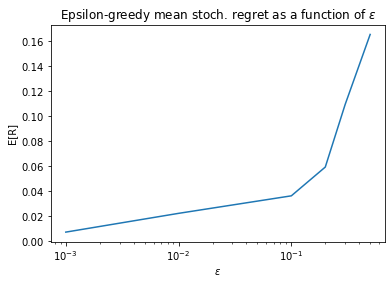

In [16]:
n_arms=10
n_steps=1000
epsilons = [.001, .01, .1, .2, .3, .5]
mean_regrets = [
    Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=eps)).stochastic_regret_summary()['E[R]'].values 
    for eps in epsilons
]

plt.semilogx(epsilons, mean_regrets)
plt.title('Epsilon-greedy mean stoch. regret as a function of $\epsilon$')
plt.xlabel('$\epsilon$')
plt.ylabel('E[R]')

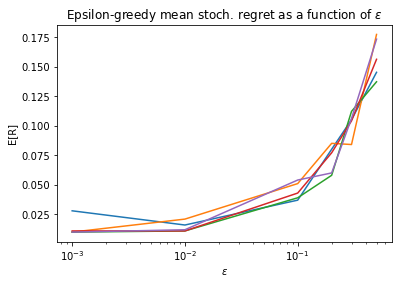

In [36]:
for i in range(5):
    n_arms=10
    n_steps=1000
    epsilons = [.001, .01, .1, .2, .3, .5]
    mean_regrets = [
    Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=eps)).stochastic_regret_summary()['E[R]'].values 
    for eps in epsilons
    ]

    plt.semilogx(epsilons, mean_regrets)
    plt.title('Epsilon-greedy mean stoch. regret as a function of $\epsilon$')
    plt.xlabel('$\epsilon$')
    plt.ylabel('E[R]')
    


### 1.2 Comparing regret in the stochastic case

It is important to repeat the experiment to have a good estimate of the variance of the regret as algorithms are randomized themselves.

The following code runs our 2 bandits: EpsilonGreedy, WeightedRandomBandit and compute a confidence interval on their regret.

In [63]:
# Experiment parameters
n_arms = 10
n_repeats = 30
n_steps = 1000
# Algos to test 
bandit_classes = [EpsilonGreedy, WeightedRandomBandit]
bandit_params = [{'epsilon':.02}, {}]
# Metric to evaluate performance
stochastic_regret = defaultdict(list)
# Run the experiments
for _ in range(n_repeats):
    for bandit_class, bandit_param in zip(bandit_classes, bandit_params):
        exp = Experiment(n_arms, n_steps)
        exp.run(bandit_class(n_arms, **bandit_param))
        stochastic_regret[bandit_class.__name__] += [exp.mean_stochastic_regret]
# Results
for bandit_class in bandit_classes:
    print("E[R] CI for", bandit_class.__name__, ":", 
          np.percentile(stochastic_regret[bandit_class.__name__], [.05, .95]))

E[R] CI for EpsilonGreedy : [0.01301301 0.01301301]
E[R] CI for WeightedRandomBandit : [0.07819419 0.08028428]


What do you observe ?
  - are the confidence intervals tight ?
  - which algorithm would you recommend ?
  - can you explain the behavior of WeightedRandomBandit ?

#### Yes Confidence Intervals are tight
#### EpsilonGreedy is recommended
#### The intervals are really tight in WeightedRandomBandit


#### Insights (optional)

You can use the following code to understand the behavior of your algorithm

In [38]:
Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms)).exploration_pull_ratio

0.10510510510510511

In [39]:
Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms)).arm_plays_summary()

,true_mean_reward,pull_count,observed_mean_reward
5,0.000000,8.0,0.000000
8,0.001001,10.0,0.000000
3,0.195195,13.0,0.076923
2,0.687688,12.0,0.666667
4,0.892893,31.0,0.935484
0,0.952953,22.0,0.909091
9,0.962963,9.0,0.777778
6,0.971972,40.0,0.950000
1,0.978979,26.0,0.961538
7,0.990991,828.0,0.992754


### 1.3 Cumulated Regret behavior

Use the code below to trace cumulated regret of E-greedy

- comment using your theoretical knowledge on regret bounds - is it good ?
- change the explore/exploit tradeoff; comment your results
- change the nber of arms; comment your results
- change the nber of steps; comment your results

In [40]:
n_arms=10
n_steps=10**4

     E[R]  E[Delta]     Rn
0  0.0355    0.9923  355.0


<AxesSubplot:title={'center':'Cumulated Regret over Time'}>

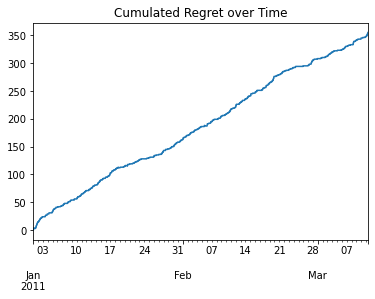

In [41]:
exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=.1))
print(exp.stochastic_regret_summary())
cumul_data = exp.cumulated_regret_summary()
cumul_data['cumulated_stochastic_regret'].plot(title='Cumulated Regret over Time')

     E[R]  E[Delta]     Rn
0  0.0357    0.9912  357.0
    E[R]  E[Delta]     Rn
0  0.035    0.9929  350.0
    E[R]  E[Delta]     Rn
0  0.035    0.9907  350.0
     E[R]  E[Delta]     Rn
0  0.0347     0.993  347.0
     E[R]  E[Delta]     Rn
0  0.0344    0.9934  344.0


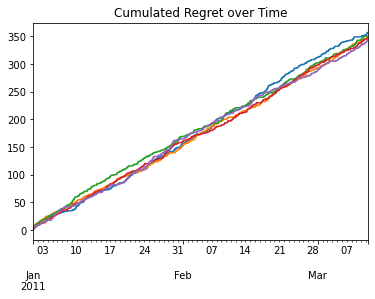

In [43]:
for i in range(5):
    exp = Experiment(n_arms, n_steps).run(EpsilonGreedy(n_arms, epsilon=.1))
    print(exp.stochastic_regret_summary())
    cumul_data = exp.cumulated_regret_summary()
    cumul_data['cumulated_stochastic_regret'].plot(title='Cumulated Regret over Time')
    

## 2. [The Bizz] Implement your algorithm

### 2.1 Your Bandit implementation
- Choose one algorithm among (UCB, Thompson Sampling and, optionally, EXP3)
- You will implement it using the Bandit API defined above
- You can validate it minimally using `test_API()`

In [74]:
class MyBandit(Bandit):
    def __init__(self, n_arms, epsilon=.1):
        Bandit.__init__(self, n_arms)
        self.epsilon = epsilon
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        if np.random.random() < self.epsilon:
            arm = np.random.choice(np.arange(self.n_arms))
            return arm
        arms_weights = self.reward_sum_per_arm / self.actions_per_arm
        arms_weights = self.reward_sum_per_arm + np.sqrt(2*np.log(np.sum(self.actions_per_arm))/self.actions_per_arm)
        return np.argmax(arms_weights)

    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] += 1
        self.reward_sum_per_arm[arm] += reward

In [75]:
test_API(MyBandit)

MyBandit sounds correct.


In [76]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(MyBandit(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.07007,0.991992,70.0


In [77]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(MyBandit(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.08008,0.992993,80.0


In [78]:
n_arms=10
n_steps=1000
exp = Experiment(n_arms, n_steps).run(MyBandit(n_arms))
exp.stochastic_regret_summary()

,E[R],E[Delta],Rn
0,0.055055,0.98999,55.0


### 2.2 Regret of your algorithm

Reuse the code that we saw to study the regret of EpsilonGreedy and apply it to your algorithm

- is it better than E-greedy ? is it expected ?
- is it stable when you change the number of arms ? of rounds ?
- is it stable when you change parameters of your algorithm (if any) ?
- based on the results of other students, which algorithm would you recommend ?

### 2.3 (optional) adversarial mode

The `Experiment` class has an option to simulate a simple adversarial bandit mode. E.g. `Experiment(n_arms, n_steps=10**5, adversarial=10)`.

- Rerun your experiments with this option
- Are your previous conclusions robust ?
- (optional) look at the adversarial code - is it the worst adversary we can expect ?